# Example of functions implementation for hyper params optimization of Gensim LDA topic model

# Ordinary imports

In [1]:
import numpy as np
import pandas as pd
import math
import csv

from datetime import datetime

import os.path
from os import path
import time

import matplotlib.pyplot as plt
import seaborn as sns

import re
import scipy
import nltk
import gensim
import spacy

from functools import partial
import json

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
fontsize_reg = 12
fontsize_title = 16
from pylab import rcParams
rcParams['figure.facecolor'] = '1'
rcParams['figure.figsize'] = [8.0, 3.5]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 600

rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'large'

In [4]:
import string

import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag

import nltk
nltk.download('wordnet')

from nltk.stem.porter import PorterStemmer # simple one
from nltk.stem.snowball import SnowballStemmer # Porter 2
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dany-\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dany-\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Imports of custom functions for two step hyper param optimization and experiment

In [5]:
import topic_model_hyper_param_opt

# Some constants (path and random seeed)

In [6]:
some_constants = pd.read_csv('some_constants.txt', sep=',', delimiter = ",", header='infer', index_col='variable_name')
some_constants

,value
variable_name,
directory_path,C:/DAN/t_systems/topic_model_lda_hyper_params_opt
random_seed,420


In [7]:
# Path to folder with directory is a constant value that stores in .txt
# You can change them in some_constants.txt file or define them on your own.
directory_path = str(some_constants.loc['directory_path'][0])
random_seed = int(some_constants.loc['random_seed'][0])
print(random_seed)
print(directory_path)

420
C:/DAN/t_systems/topic_model_lda_hyper_params_opt


# General pipeline for two stage hyper params optimization

## Read the data

In [8]:
# Read the data with texts
texts_df = pd.read_csv('datasets/texts_10kGNAD.csv')
texts_df['text'] = texts_df['text'].astype('str')
texts_df.tail(2)

,Unnamed: 0,label,text
10271,10271,Wissenschaft,Klimatische Verschlechterungen dürften zur Auf...
10272,10272,Wissenschaft,Knochen können zum Verständnis des Lebens in d...


In [9]:
# Filter NaNs if needed.
# Sometimes preprocessing fails because of 'nan' texts.
# texts_df = texts_df[texts_df['text'] != 'nan']

## Preprocessing

In [10]:
custom_stop_words = [
    'nan', 'ja', 'nein', 'nr', 'nee',
    'fuer', 'ueber', 'mehr', 'ab', 'beim', 
    'wurde', 'worden', 'wurden', 'wuerde', 'waere', 
    'bereits',
]

In [11]:
from topic_model_hyper_param_opt import preprocess_doc 

# Preprocess texts
# texts_df['text_preprocessed'], dictionary, bow = preprocess_series(texts_df['text'], dictionary=None)
texts_df['text_preprocessed'] = texts_df['text'].apply(
    lambda x: preprocess_doc(x, lang='german', sw=True, custom_stop_words=custom_stop_words)
)

## Preparing objects for model

In [12]:
from topic_model_hyper_param_opt import create_document_term_matrix_from_texts_series 

# Create document term matrix.
# min_df params controls how many rare words to delete.
# Set min_df as 0.0 for full dicrionary
data_vect, vectorizer, data_dtm = create_document_term_matrix_from_texts_series(
    texts_df['text_preprocessed'],
    ngram_range=(1, 2),
    index_for_dtm=texts_df.index,
    vocabulary_cut_offs={
        'min_df': 0.005, 
        'max_df': 0.999
    }
)
data_dtm.tail(2)

,abbau,abend,abends,abgang,abgeben,abgegeben,abgehalten,abgelaufenen,abgelehnt,abgeordnete,...,zweimal,zweite,zweiten,zweiten mal,zweiten weltkrieg,zweitens,zweiter,zweites,zwingen,zwoelf
10271,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
10272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Create the gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtm.transpose()))

# Create the vocabulary dictionary.
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

## Stage 1 optimization

In [34]:
from topic_model_hyper_param_opt import stage_1_optimization_gensim_ldamodel 

# Find almost all optimal params of LDA model with fixed number of topics.
params_optimal_stage_1, trials_stage_1 = stage_1_optimization_gensim_ldamodel(
    corpus=corpus, 
    id2word=id2word,
    metric_to_optimize='coherence',
    stage_1_params={
        'num_of_topics_min': 8,
        'num_of_topics_max': 16,
        'passes_param': 5,
        'iterations_param': 55,
        'max_eval_param': 30, # how many trials, set it 1000+
        'timeout_param': 86400, # time limit
    },
    random_seed=random_seed
)

100%|████████████████████████████████████████████████| 30/30 [20:43<00:00, 41.43s/trial, best loss: 1.5938251531742114]


In [35]:
from topic_model_hyper_param_opt import trails_of_hyper_opt_to_dataframe 

# Save df with trials.
trials_stage_1_df = trails_of_hyper_opt_to_dataframe(trials_stage_1)

trials_stage_1_df.to_csv('hyper_opt_outputs/trials_stage_1_df.csv')

In [36]:
import json

# Save optimal params from Stage 1.
with open('hyper_opt_outputs/params_optimal_stage_1.json', 'w') as json_file:
    json.dump(params_optimal_stage_1, json_file)
json_file.close()

In [37]:
# Read the params_optimal_stage_1 to optimize only number of topics in STage 2.
with open('hyper_opt_outputs/params_optimal_stage_1.json') as json_file:
    params_optimal_stage_1 = json.load(json_file)
json_file.close()

print(params_optimal_stage_1)

{'alpha': 0.0001, 'decay': 0.6, 'offset': 64, 'eta': None, 'gamma_threshold': 0.0008, 'minimum_probability': 0.05}


## Stage 2 optimization

In [38]:
from topic_model_hyper_param_opt import stage_2_optimization_gensim_ldamodel 

# Optimize only number of topics with fixed optimal params from Stage 1.
optimal_params_result, trials_stage_2 = stage_2_optimization_gensim_ldamodel(
    corpus=corpus, 
    id2word=id2word,
    params_optimal_stage_1=params_optimal_stage_1,
    metric_to_optimize='coherence',
    stage_2_params={
        'num_of_topics_min': 6,
        'num_of_topics_max': 20,
        'passes_param': 5,
        'iterations_param': 55,
        'max_eval_param': 15, # how many trials, set it 1000+
        'timeout_param': 86400, # time limit
    },
    random_seed=random_seed
)
print(optimal_params_result)

100%|████████████████████████████████████████████████| 15/15 [09:07<00:00, 36.48s/trial, best loss: 1.5938251531742114]
{'alpha': 0.0001, 'decay': 0.6, 'offset': 64, 'eta': None, 'gamma_threshold': 0.0008, 'minimum_probability': 0.05, 'num_topics': 8.0}


In [39]:
from topic_model_hyper_param_opt import trails_of_hyper_opt_to_dataframe 

# Save df with trials.
trials_stage_2_df = trails_of_hyper_opt_to_dataframe(trials_stage_2)

trials_stage_2_df.to_csv('hyper_opt_outputs/trials_stage_2_df.csv')

In [40]:
# Save optimal params for both stages.
with open('hyper_opt_outputs/optimal_params_result.json', 'w') as json_file:
    json.dump(optimal_params_result, json_file)
json_file.close()

## Build a model with optimal params

In [41]:
with open('hyper_opt_outputs/optimal_params_result.json') as json_file:
    optimal_params_result = json.load(json_file)
json_file.close()

print(optimal_params_result)

lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    random_state=random_seed,
    passes=5,
    iterations=55,
    **optimal_params_result
)

{'alpha': 0.0001, 'decay': 0.6, 'offset': 64, 'eta': None, 'gamma_threshold': 0.0008, 'minimum_probability': 0.05, 'num_topics': 8.0}


In [42]:
# Check the value of optimized metric.
coherence_lda_model = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
coherence_lda_model.get_coherence()

-1.5938251531742114

## Plots. Trials and optimal number of topics

In [43]:
# Read trials df from saved files.
trials_stage_2_df = pd.read_csv('hyper_opt_outputs/trials_stage_2_df.csv')
trials_stage_1_df = pd.read_csv('hyper_opt_outputs/trials_stage_1_df.csv')

# Convert string representation of dictionary to dict
from ast import literal_eval

trials_stage_1_df['result'] = trials_stage_1_df['result'].apply(lambda x: literal_eval(x))
trials_stage_1_df['misc'] = trials_stage_1_df['misc'].apply(lambda x: literal_eval(x))

trials_stage_2_df['result'] = trials_stage_2_df['result'].apply(lambda x: literal_eval(x))
trials_stage_2_df['misc'] = trials_stage_2_df['misc'].apply(lambda x: literal_eval(x))

trials_stage_1_df.tail(2)

,Unnamed: 0,state,tid,spec,result,misc,exp_key,owner,version,book_time,refresh_time,alpha,decay,eta,gamma_threshold,minimum_probability,num_topics,offset,loss,status
28,28,2,28,NaN,"{'loss': 1.5938251531742114, 'status': 'ok'}","{'tid': 28, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': ...",NaN,NaN,0,2021-05-03 23:30:26.944,2021-05-03 23:31:01.863,0.0001,0.6,NaN,0.0008,0.05,8.0,64,1.593825,ok
29,29,2,29,NaN,"{'loss': 1.852790210245757, 'status': 'ok'}","{'tid': 29, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'alpha': ...",NaN,NaN,0,2021-05-03 23:31:01.874,2021-05-03 23:31:38.318,0.0005,0.6,NaN,0.0008,0.05,10.0,64,1.852790,ok


Text(0.05, -0.1, 'note_text_placeholder')

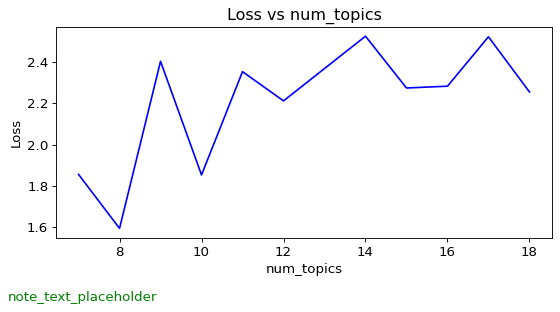

In [44]:
# Show the loss vs. number of topics of Stage 2 optimization.
f, ax = plt.subplots(1)
trials_stage_2_df = trials_stage_2_df.sort_values(by='num_topics')
xs = trials_stage_2_df['num_topics']
ys = trials_stage_2_df['loss']
plt.plot(xs, ys, linestyle='solid',color='blue')
ax.set_title('Loss vs num_topics')
ax.set_xlabel('num_topics')
ax.set_ylabel('Loss')
f.text(0.05, -0.1, 'note_text_placeholder', fontsize=12, color='green')

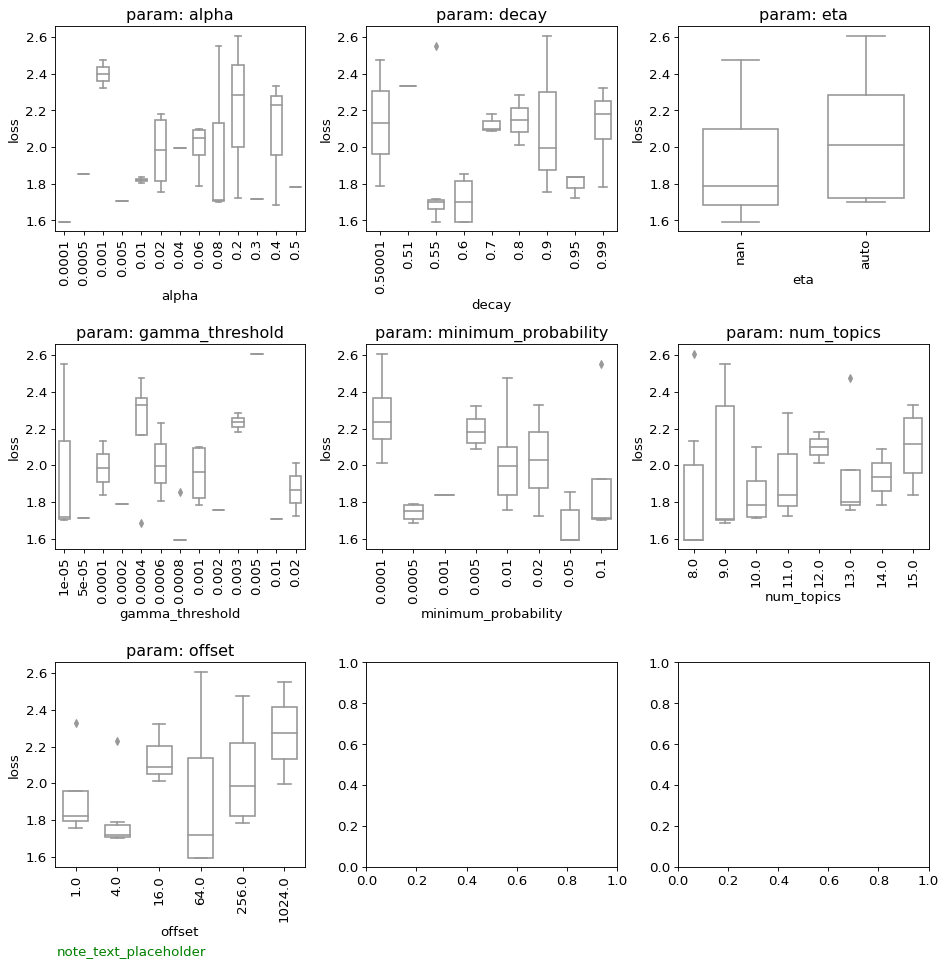

In [45]:
from topic_model_hyper_param_opt import plot_loss_vs_params 

# Plot the loss vs. params of Stage 1 optimization
plot_loss_vs_params(
    trials_stage_1_df,
    quantile_of_loss=1.0,
    ncols_plot=3,
    file_path='hyper_opt_outputs/' + 'test.png',
    note_text='note_text_placeholder',
    save_plot=True,
    show_plot=True
)

# Show model results

## Print topics as a result of the model

In [46]:
# Print some 15 random topics
lda_model.print_topics(num_topics=15)

[(0,
  '0.007*"trainer" + 0.006*"league" + 0.006*"fussball" + 0.006*"rapid" + 0.006*"fc" + 0.006*"salzburg" + 0.005*"spiel" + 0.005*"zwei" + 0.005*"team" + 0.005*"minute"'),
 (1,
  '0.018*"standard" + 0.008*"koennen" + 0.008*"gibt" + 0.007*"sagt" + 0.007*"menschen" + 0.007*"immer" + 0.005*"viele" + 0.005*"schon" + 0.005*"geht" + 0.005*"etwa"'),
 (2,
  '0.008*"schon" + 0.007*"ersten" + 0.006*"zwei" + 0.005*"spiel" + 0.005*"gut" + 0.005*"the" + 0.004*"drei" + 0.004*"immer" + 0.004*"wien" + 0.004*"fan"'),
 (3,
  '0.019*"prozent" + 0.017*"euro" + 0.009*"wien" + 0.009*"millionen" + 0.008*"sei" + 0.006*"rund" + 0.006*"spoe" + 0.005*"jahr" + 0.005*"laut" + 0.005*"oevp"'),
 (4,
  '0.010*"apple" + 0.008*"google" + 0.007*"koennen" + 0.007*"nutzer" + 0.007*"neue" + 0.006*"allerdings" + 0.006*"window" + 0.006*"unternehmen" + 0.005*"microsoft" + 0.005*"android"'),
 (5,
  '0.010*"sagte" + 0.009*"sei" + 0.007*"polizei" + 0.007*"menschen" + 0.006*"regierung" + 0.006*"seien" + 0.005*"seit" + 0.005*"zwe

In [47]:
# Or in shorter former with only top 5 words for each topic

from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, strip_numeric

print('Print short description of topics')

lda_topics = lda_model.show_topics(num_topics=100, num_words=5, formatted=True)

topics = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]

for topic in lda_topics:
    to_append = preprocess_string(topic[1], filters)
    print(topic[0], to_append)
    topics.append(to_append)

Print short description of topics
0 ['trainer', 'league', 'fussball', 'rapid', 'fc']
1 ['standard', 'koennen', 'gibt', 'sagt', 'menschen']
2 ['schon', 'ersten', 'zwei', 'spiel', 'gut']
3 ['prozent', 'euro', 'wien', 'millionen', 'sei']
4 ['apple', 'google', 'koennen', 'nutzer', 'neue']
5 ['sagte', 'sei', 'polizei', 'menschen', 'regierung']
6 ['wien', 'jahren', 'menschen', 'forscher', 'etwa']
7 ['eu', 'oesterreich', 'sei', 'wien', 'fluechtlinge']


0, 1, 2, 3, 4, 5, 6, 7, 8, Empty subplot, 

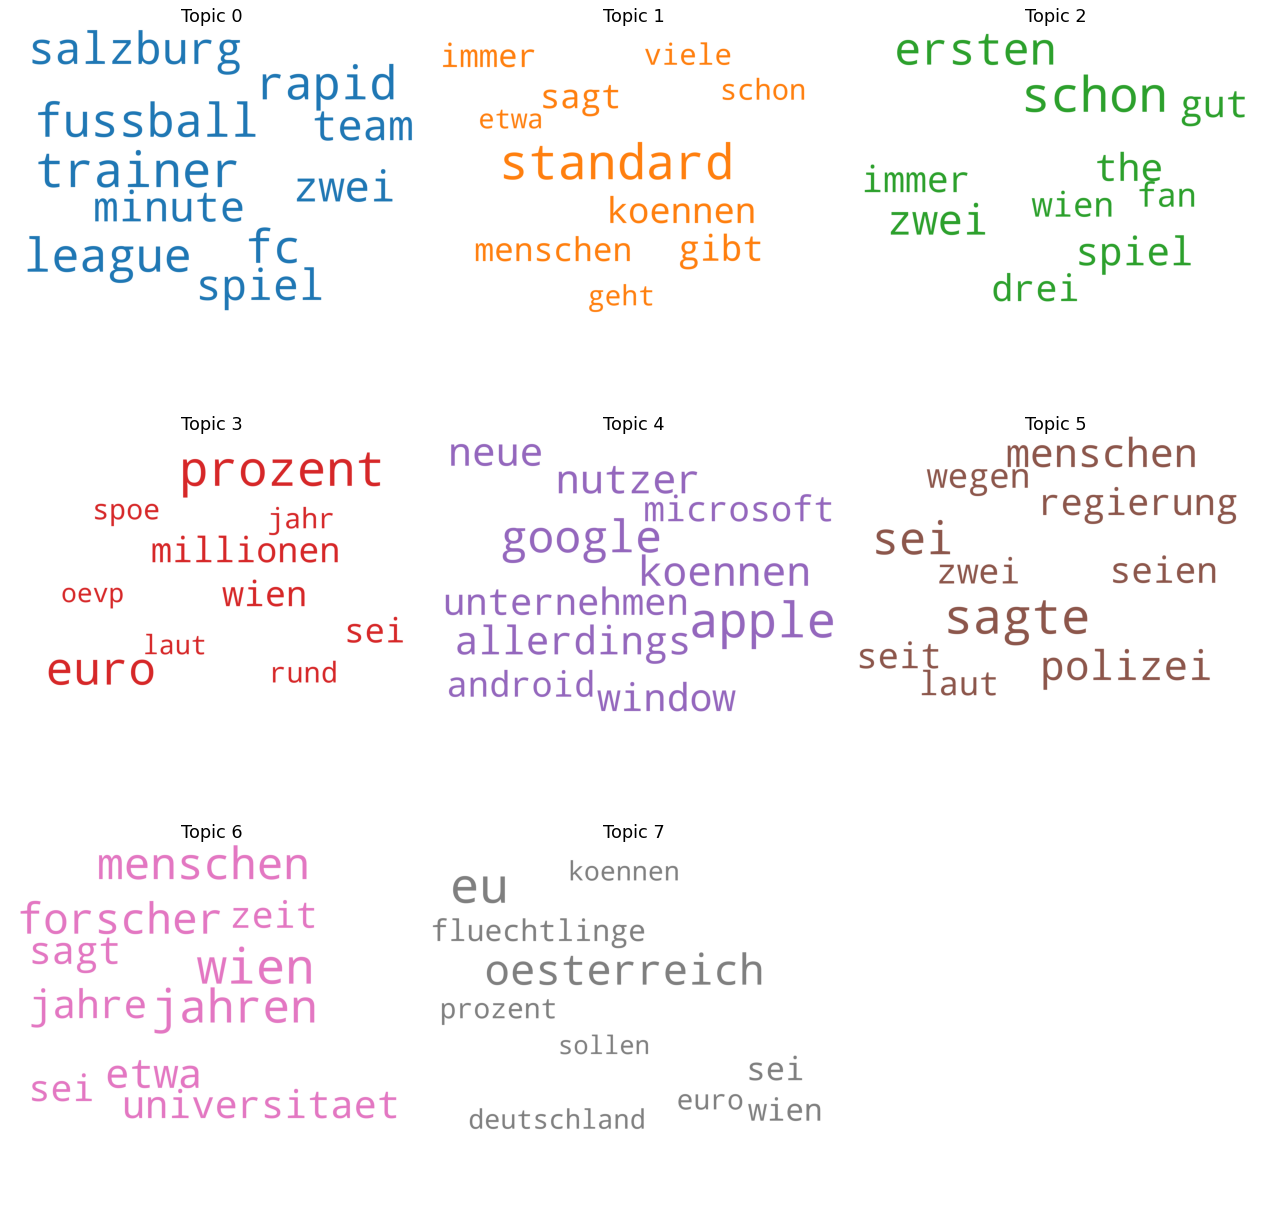

In [49]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# cols = [color for name, color in mcolors.CSS4_COLORS.items()][34:]  # more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] * 10

cloud = WordCloud(stopwords=custom_stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=100, formatted=False)

# Change nrows, ncols and figsize to compress/expand the plot size.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    try:
        print(i, end=', ')
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    except:
        print('Empty subplot', end=', ')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## pyLDAVis

In [50]:
word2id = dict((k, v) for k, v in vectorizer.vocabulary_.items())
d = gensim.corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=d)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.034981  0.058794       1        1  19.889572
5      0.028456  0.171251       2        1  17.730316
7      0.081163  0.029110       3        1  13.076582
1      0.090965 -0.085683       4        1  12.664753
2     -0.108359 -0.065471       5        1  10.275237
6      0.041999 -0.008510       6        1   9.683697
4      0.065346 -0.105272       7        1   9.428140
0     -0.234550  0.005782       8        1   7.251703, topic_info=          Term         Freq        Total Category  logprob  loglift
1579        eu  4030.000000  4030.000000  Default  30.0000  30.0000
303   standard  3766.000000  3766.000000  Default  29.0000  29.0000
7      prozent  6710.000000  6710.000000  Default  28.0000  28.0000
455       euro  6225.000000  6225.000000  Default  27.0000  27.0000
937      apple  1315.000000  1315.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
465      steht   355.345697  1704.541122   Topic8  -5.6030   1.0560
486     ersten   366.903730  2918.376005   Topic8  -5.5710   0.5503
552      sagte   358.554858  5421.030963   Topic8  -5.5940  -0.0920
122       seit   344.767314  4859.948919   Topic8  -5.6332  -0.0220
120       wien   343.700975  6370.701409   Topic8  -5.6363  -0.2958

[601 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2092      1  0.125430   absurd
2092      2  0.125430   absurd
2092      3  0.041810   absurd
2092      4  0.599276   absurd
2092      5  0.055747   absurd
...     ...       ...      ...
1430      4  0.017807  zweiten
1430      5  0.340873  zweiten
1430      6  0.099209  zweiten
1430      7  0.032222  zweiten
1430      8  0.223857  zweiten

[3225 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 8, 2, 3, 7, 5, 1])

In [51]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# What is the Dominant topic and its percentage contribution in each document

In [52]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                # print(topic_num, end=',')
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# .apply(lambda x: " ".join(x))
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=list(texts_df['text_preprocessed']))

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.tail(2)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
10271,10271,6.0,1.0,"wien, jahren, menschen, forscher, etwa, jahre, universitaet, sagt, sei, zeit","[klimatische, duerften, aufgabe, siedlung, gefuehrt, prozess, menschen, sahelzone, heute, betrif..."
10272,10272,6.0,1.0,"wien, jahren, menschen, forscher, etwa, jahre, universitaet, sagt, sei, zeit","[knochen, koennen, verstaendnis, lebens, vergangenheit, beitragen, heutiger, relevanz, arbeit, g..."


Text(0, 0.5, 'Number of documents')

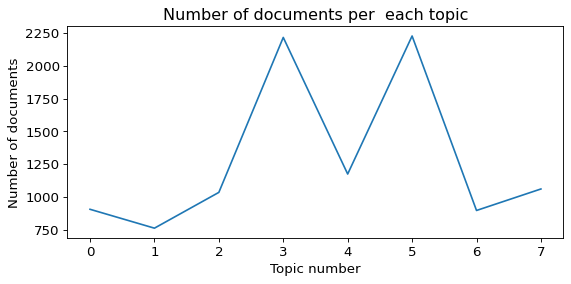

In [53]:
# Plot the number of documents per each dominant topic
plt.plot(df_dominant_topic.groupby(by='Dominant_Topic').agg('count')['Text'])
plt.title('Number of documents per  each topic')
plt.xlabel('Topic number')
plt.ylabel('Number of documents')

# The most representative document for each topic

In [54]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet['index_num'] = sent_topics_sorteddf_mallet.index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text", "index_num"]

sent_topics_sorteddf_mallet
sent_topics_sorteddf_mallet['Representative Text original'] = np.nan

for i in range(0, len(sent_topics_sorteddf_mallet['index_num'])):
    sent_topics_sorteddf_mallet['Representative Text original'][i] = texts_df['text'].iloc[sent_topics_sorteddf_mallet['index_num'][i]]

# Show
for i in range(0, len(sent_topics_sorteddf_mallet.index)):
    print('TOPIC', i)
    print(sent_topics_sorteddf_mallet['Representative Text original'][i][:400])
    if len(sent_topics_sorteddf_mallet['Representative Text original'][i]) > 400:
        print('   !!! TEXT IS CUTTED BY [:400] LIMIT !!!')
    print()
    
sent_topics_sorteddf_mallet.head(2)

TOPIC 0
Die größte Volkswirtschaft Südamerikas ist in der Rezession, das bringt auch die Planung des Budgets etwas aus dem Ruder. Der Volltext dieses auf Agenturmeldungen basierenden Artikels steht aus rechtlichen Gründen nicht mehr zur Verfügung.

TOPIC 1
Der Biologe Martin Leeb sucht nach dem genetischen Programm, das die Ausdifferenzierung von Stammzellen startet. STANDARD: Nach sechs Jahren an der University of Cambridge hat Sie der  Wiener Wissenschafts-, Forschungs- und Technologiefonds WWTF mit einer  Förderung zurück nach Wien geholt. Haben Sie eine Rückkehr angestrebt? Leeb: Da ich zwei Kinder habe, war es schon immer das Ziel von mir und  
   !!! TEXT IS CUTTED BY [:400] LIMIT !!!

TOPIC 2
Der Film "Crouching Tiger, Hidden Dragon: Sword of Destiny" ist ab Freitag abrufbar. Los Gatos / Wien – Schwertkämpfer und exotische Ninjas, die auf Baumwipfeln gegeneinander kämpfen: Der mehrfach preisgekrönte chinesisch-taiwanische Blockbuster Tiger and Dragon aus dem Jahr 2000 mit Chow Y

c:\python37\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\python37\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text,index_num,Representative Text original
0,0.0,1.0,"trainer, league, fussball, rapid, fc, salzburg, spiel, zwei, team, minute","[groesste, volkswirtschaft, suedamerikas, rezession, bringt, planung, budget, ruder, volltext, b...",9653,"Die größte Volkswirtschaft Südamerikas ist in der Rezession, das bringt auch die Planung des Bud..."
1,1.0,1.0,"standard, koennen, gibt, sagt, menschen, immer, viele, schon, geht, etwa","[biologe, martin, leeb, sucht, genetischen, programm, stammzellen, startet, standard, sechs, jah...",10106,"Der Biologe Martin Leeb sucht nach dem genetischen Programm, das die Ausdifferenzierung von Stam..."
